In [ ]:
# minimum correlation > 0.8
# number of cluster by annual consumption (last 5 years)
# number of cluster (elbow, silouhette)
# taux de variation annual per contrats (if 0 stop, démarage)

In [10]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import os

In [4]:
import sqlite3

In [92]:
from onee.utils import create_monthly_matrix

In [5]:
PROJECT_ROOT = Path(os.getcwd()).resolve().parents[0]


In [6]:
db_regional_path = PROJECT_ROOT / 'data/ONEE_Regional_COMPLETE.db'
db_dist_path = PROJECT_ROOT / 'data/ONEE_Distributeurs_consumption.db'
df_cd_path = PROJECT_ROOT / 'data/cd_data_2013_2023.csv'

In [131]:
db_regional = sqlite3.connect(db_regional_path)
TARGET_REGION = "Tanger-Tétouan-Al Hoceïma"

query_regional = f"""
SELECT Year as annee, Month as mois, Activity as activite, 
       (MWh * 1000)/"Nbr Clients" as cons_moy_kwh, temp as temperature
FROM monthly_data
WHERE Region = '{TARGET_REGION}'
ORDER BY Year, Month, Activity
"""

# query_regional = f"""
#     SELECT Year as annee, Month as mois, Activity as activite, 
#         MWh * 1000 as consommation_kwh, temp as temperature
#     FROM monthly_data
#     WHERE Region = '{TARGET_REGION}'
#     ORDER BY Year, Month, Activity
# """

df_regional = pd.read_sql_query(query_regional, db_regional)
db_regional.close()


In [132]:
df_regional

,annee,mois,activite,cons_moy_kwh,temperature
0,2013,1,Administratif,3.230689e+02,12.445161
1,2013,1,Force_Motrice_Agricole,1.890006e+02,12.445161
2,2013,1,Force_Motrice_Industrielle,3.618664e+02,12.445161
3,2013,1,General,1.619988e+04,12.445161
4,2013,1,General,NaN,12.445161
...,...,...,...,...,...
1177,2023,12,General,2.100580e+07,13.500000
1178,2023,12,Menages,5.572608e+01,13.500000
1179,2023,12,Patentes,1.699175e+02,13.500000
1180,2023,12,Public,1.347572e+03,13.500000


In [120]:
df_regional.isna().sum()

annee            0
mois             0
activite         0
nbr_clients     68
temperature    108
dtype: int64

In [117]:
df_regional["nbr_clients"] = df_regional["nbr_clients"].fillna(0)


In [114]:
df = pd.read_csv(df_cd_path)

## Activite vs secteur vs contrat

In [8]:
len(df["activite"].unique())

19

In [9]:
len(df["secteur"].unique())

29

In [ ]:
summary = (
    df.groupby("activite")["partenaire"]
    .agg(["nunique", lambda x: ", ".join(sorted(x.unique()))])
    .reset_index()
    .rename(columns={"nunique": "Nb_partenaires", "<lambda_0>": "Partenaires"})
)

import pandas as pd
from IPython.display import display

display(summary)

<Axes: xlabel='Nb_partenaires', ylabel='activite'>

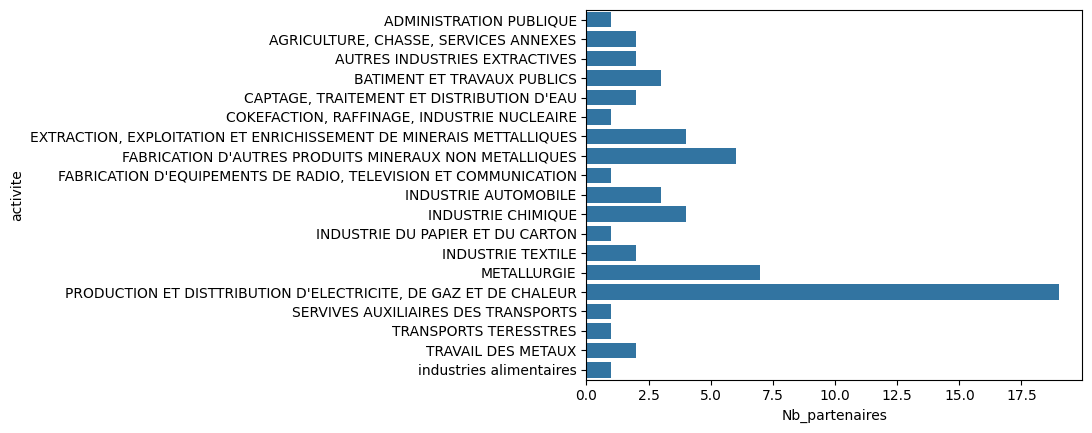

In [24]:
sns.barplot(data=summary, x="Nb_partenaires", y="activite")

## Rate of change activite

In [36]:
df_rate = df.groupby(["activite", "annee", "mois"], as_index=False).agg({
    "consommation": "sum",
    "temperature": "mean"
})

In [18]:
df_rate

,activite,annee,mois,consommation,temperature
0,ADMINISTRATION PUBLIQUE,2013,1,1261.838,12.445161
1,ADMINISTRATION PUBLIQUE,2013,2,1152.520,11.139286
2,ADMINISTRATION PUBLIQUE,2013,3,1102.330,13.570968
3,ADMINISTRATION PUBLIQUE,2013,4,932.235,15.416667
4,ADMINISTRATION PUBLIQUE,2013,5,931.057,17.103226
...,...,...,...,...,...
2503,industries alimentaires,2023,8,389.649,25.648387
2504,industries alimentaires,2023,9,5483.054,22.186667
2505,industries alimentaires,2023,10,10099.442,20.906452
2506,industries alimentaires,2023,11,13383.747,16.206667


In [27]:
2023 - 2014

9

In [47]:
for activite in df_rate['activite'].unique():
    for i in range(2014, 2024):
        mask = (df_rate['activite'] == activite) & (df_rate['annee'] == i)
        prev_mask = (df_rate['activite'] == activite) & (df_rate['annee'] == i - 1)

        # sort within-year so rows line up (important!)
        cur = df_rate.loc[mask].sort_values('mois')['consommation'].to_numpy()
        prev = df_rate.loc[prev_mask].sort_values('mois')['consommation'].to_numpy()

        if len(cur) == len(prev) and len(cur) > 0:
            df_rate.loc[mask, 'consommation_monthly_cr'] = cur / prev
        else:
            df_rate.loc[mask, 'consommation_monthly_cr'] = float('nan')

C:\Users\Soufiane.AITELAOUAD\AppData\Local\Temp\ipykernel_15772\891501711.py:11: RuntimeWarning: invalid value encountered in divide
  df_rate.loc[mask, 'consommation_monthly_cr'] = cur / prev
C:\Users\Soufiane.AITELAOUAD\AppData\Local\Temp\ipykernel_15772\891501711.py:11: RuntimeWarning: divide by zero encountered in divide
  df_rate.loc[mask, 'consommation_monthly_cr'] = cur / prev
C:\Users\Soufiane.AITELAOUAD\AppData\Local\Temp\ipykernel_15772\891501711.py:11: RuntimeWarning: invalid value encountered in divide
  df_rate.loc[mask, 'consommation_monthly_cr'] = cur / prev
C:\Users\Soufiane.AITELAOUAD\AppData\Local\Temp\ipykernel_15772\891501711.py:11: RuntimeWarning: divide by zero encountered in divide
  df_rate.loc[mask, 'consommation_monthly_cr'] = cur / prev
C:\Users\Soufiane.AITELAOUAD\AppData\Local\Temp\ipykernel_15772\891501711.py:11: RuntimeWarning: invalid value encountered in divide
  df_rate.loc[mask, 'consommation_monthly_cr'] = cur / prev
C:\Users\Soufiane.AITELAOUAD\AppD

In [51]:
df_rate = df_rate[~(df_rate["annee"] == 2013)]

In [56]:
df_rate[df_rate["consommation_monthly_cr"].isna()].head(30)

,activite,annee,mois,consommation,temperature,consommation_monthly_cr
408,BATIMENT ET TRAVAUX PUBLICS,2014,1,0.0,12.403226,NaN
409,BATIMENT ET TRAVAUX PUBLICS,2014,2,0.0,12.103571,NaN
410,BATIMENT ET TRAVAUX PUBLICS,2014,3,0.0,13.432258,NaN
411,BATIMENT ET TRAVAUX PUBLICS,2014,4,0.0,16.603333,NaN
412,BATIMENT ET TRAVAUX PUBLICS,2014,5,0.0,18.983871,NaN
413,BATIMENT ET TRAVAUX PUBLICS,2014,6,0.0,21.203333,NaN
414,BATIMENT ET TRAVAUX PUBLICS,2014,7,0.0,22.938710,NaN
415,BATIMENT ET TRAVAUX PUBLICS,2014,8,0.0,23.738710,NaN
416,BATIMENT ET TRAVAUX PUBLICS,2014,9,0.0,22.056667,NaN
417,BATIMENT ET TRAVAUX PUBLICS,2014,10,0.0,20.638710,NaN


In [70]:
df_rate[df_rate["activite"] == "INDUSTRIE DU PAPIER ET DU CARTON"].iloc[55:80]

,activite,annee,mois,consommation,temperature,consommation_monthly_cr
1519,INDUSTRIE DU PAPIER ET DU CARTON,2018,8,19.828,25.151613,0.742010
1520,INDUSTRIE DU PAPIER ET DU CARTON,2018,9,19.551,23.993333,0.723254
1521,INDUSTRIE DU PAPIER ET DU CARTON,2018,10,31.500,19.396774,1.105729
1522,INDUSTRIE DU PAPIER ET DU CARTON,2018,11,14.026,14.733333,0.490008
1523,INDUSTRIE DU PAPIER ET DU CARTON,2018,12,0.000,13.796774,0.000000
1524,INDUSTRIE DU PAPIER ET DU CARTON,2019,1,0.000,11.993548,0.000000
1525,INDUSTRIE DU PAPIER ET DU CARTON,2019,2,0.000,12.800000,0.000000
1526,INDUSTRIE DU PAPIER ET DU CARTON,2019,3,0.000,14.741935,0.000000
1527,INDUSTRIE DU PAPIER ET DU CARTON,2019,4,0.000,15.030000,0.000000
1528,INDUSTRIE DU PAPIER ET DU CARTON,2019,5,0.000,18.993548,0.000000


In [60]:
from onee.utils import plot_var_over_time

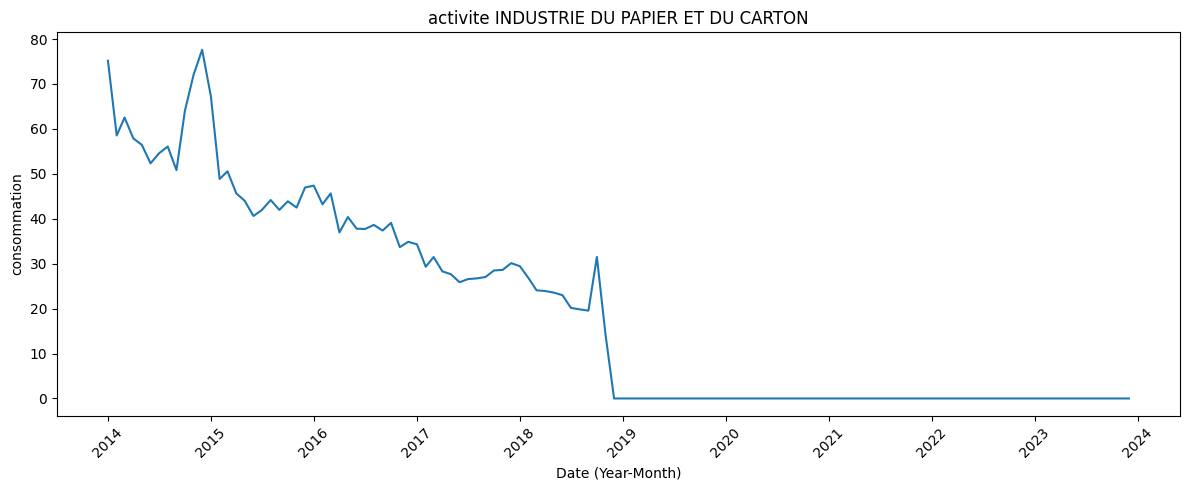

In [61]:
plot_var_over_time(df_rate, "activite","INDUSTRIE DU PAPIER ET DU CARTON", "consommation")

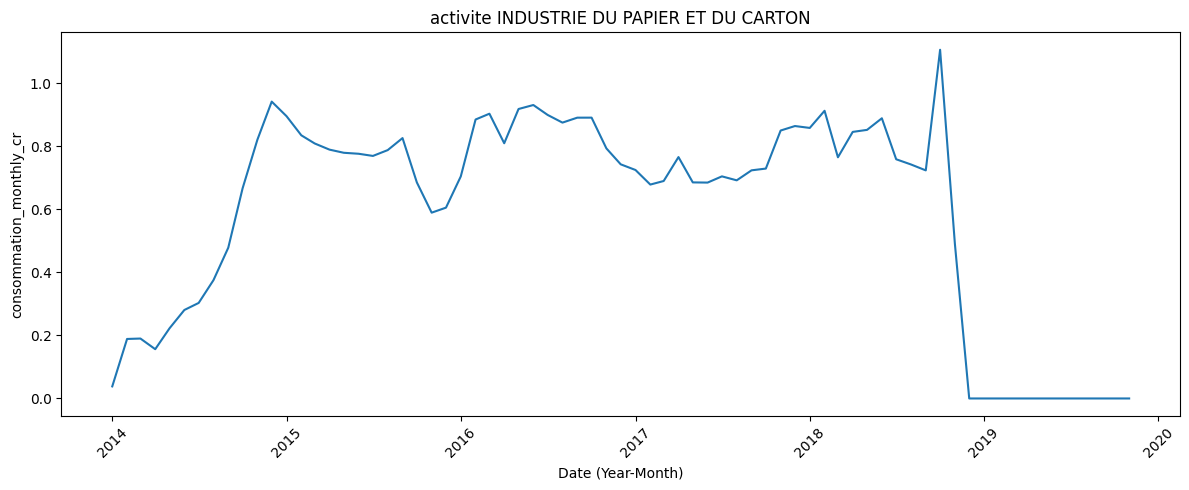

In [62]:
plot_var_over_time(df_rate, "activite","INDUSTRIE DU PAPIER ET DU CARTON", "consommation_monthly_cr")

In [72]:
df_rate[df_rate["consommation_monthly_cr"] == float("inf")]

,activite,annee,mois,consommation,temperature,consommation_monthly_cr
429,BATIMENT ET TRAVAUX PUBLICS,2015,10,28.606,19.729032,inf
430,BATIMENT ET TRAVAUX PUBLICS,2015,11,68.709,16.060000,inf
431,BATIMENT ET TRAVAUX PUBLICS,2015,12,109.007,15.183871,inf
432,BATIMENT ET TRAVAUX PUBLICS,2016,1,130.777,13.683871,inf
433,BATIMENT ET TRAVAUX PUBLICS,2016,2,122.002,13.062069,inf
434,BATIMENT ET TRAVAUX PUBLICS,2016,3,168.730,12.493548,inf
435,BATIMENT ET TRAVAUX PUBLICS,2016,4,143.667,15.560000,inf
436,BATIMENT ET TRAVAUX PUBLICS,2016,5,149.796,17.983871,inf
437,BATIMENT ET TRAVAUX PUBLICS,2016,6,162.311,22.123333,inf
438,BATIMENT ET TRAVAUX PUBLICS,2016,7,196.178,25.103226,inf


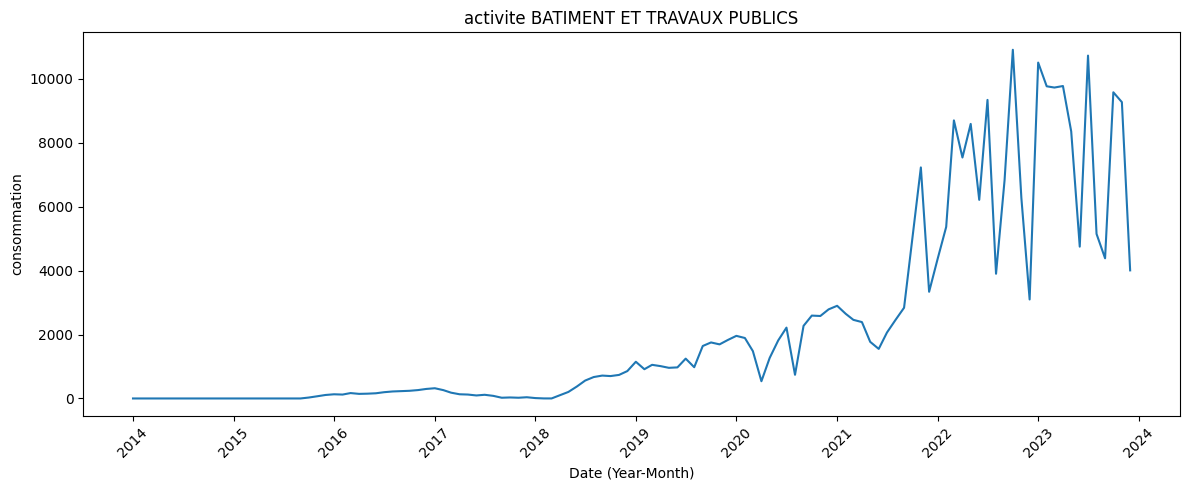

In [73]:
plot_var_over_time(df_rate, "activite","BATIMENT ET TRAVAUX PUBLICS", "consommation")

In [79]:
bad = list(df_rate[df_rate["consommation_monthly_cr"].isna()]["activite"].unique())

In [83]:
df_rate_clean = df_rate[~df_rate["activite"].isin(bad)]

In [85]:
df_rate_clean.to_csv(PROJECT_ROOT / "data/cd_data_activite_change_rate.csv")

In [ ]:
def row_sum(arr):
    result = []
    for row in arr:
        total = 0
        for val in row:
            total += val
        result.append(total)
    return np.array(result)

In [89]:
d_a = df_rate_clean[df_rate_clean["activite"] == "ADMINISTRATION PUBLIQUE"]

In [90]:
d_a

,activite,annee,mois,consommation,temperature,consommation_monthly_cr
12,ADMINISTRATION PUBLIQUE,2014,1,1250.378,12.403226,0.990918
13,ADMINISTRATION PUBLIQUE,2014,2,1118.643,12.103571,0.970606
14,ADMINISTRATION PUBLIQUE,2014,3,1072.503,13.432258,0.972942
15,ADMINISTRATION PUBLIQUE,2014,4,902.135,16.603333,0.967712
16,ADMINISTRATION PUBLIQUE,2014,5,980.410,18.983871,1.053007
...,...,...,...,...,...,...
127,ADMINISTRATION PUBLIQUE,2023,8,118.702,25.648387,1.022042
128,ADMINISTRATION PUBLIQUE,2023,9,116.398,22.186667,1.055018
129,ADMINISTRATION PUBLIQUE,2023,10,117.918,20.906452,0.982732
130,ADMINISTRATION PUBLIQUE,2023,11,127.038,16.206667,0.943847


In [93]:
monthly_matrix = create_monthly_matrix(d_a, value_col="consommation_monthly_cr")
monthly_matrix_2 = create_monthly_matrix(d_a, value_col="consommation")

In [101]:
import numpy as np

def annual_change(R_t_m, X_t_m):
    R_t_m = np.array(R_t_m, dtype=float)
    X_t_m = np.array(X_t_m, dtype=float)
    
    numerator = np.sum(X_t_m)
    denominator = np.sum(X_t_m / R_t_m)
    
    return numerator / denominator


def annual_change_prev_year(R_t_m, X_t1_m):
    R_t_m = np.array(R_t_m, dtype=float)
    X_t1_m = np.array(X_t1_m, dtype=float)
    
    numerator = np.sum(R_t_m * X_t1_m)
    denominator = np.sum(X_t1_m)
    
    return numerator / denominator


In [103]:
a = np.array([1,3,3])

In [96]:
annual_change(monthly_matrix[1], monthly_matrix_2[1])

np.float64(0.9506798696650213)

In [102]:
annual_change_prev_year(monthly_matrix[1], monthly_matrix_2[0])

np.float64(0.9506798696650213)

In [ ]:
monthly_matrix

## Rate of change

In [24]:
df_yearly = (
    df
    .groupby(["partenaire", "contrat", "activite", "secteur", "annee"], as_index=False)[["ventes", "consommation"]]
    .sum()
)

In [ ]:
for contrat in df_yearly['contrat'].unique():
    df_yearly.loc[df_yearly['contrat'] == contrat, 'consommation_rate_of_change'] = df_yearly.loc[df_yearly['contrat'] == contrat, 'consommation'].pct_change().replace({
    float('inf'): 'start',
    -1:'stop'
}).fillna('stopped')
    

In [51]:
df_yearly[df_yearly['contrat'] == 6500531]

,partenaire,contrat,activite,secteur,annee,ventes,consommation,consommation_rate_of_change
1661,PHOSBOUCRAA,6500531,AUTRES INDUSTRIES EXTRACTIVES,PHOSPHATES NATURELS.,2013,0.000,0.000,stopped
1662,PHOSBOUCRAA,6500531,AUTRES INDUSTRIES EXTRACTIVES,PHOSPHATES NATURELS.,2014,0.000,0.000,stopped
1663,PHOSBOUCRAA,6500531,AUTRES INDUSTRIES EXTRACTIVES,PHOSPHATES NATURELS.,2015,0.000,0.000,stopped
1664,PHOSBOUCRAA,6500531,AUTRES INDUSTRIES EXTRACTIVES,PHOSPHATES NATURELS.,2016,0.000,0.000,stopped
1665,PHOSBOUCRAA,6500531,AUTRES INDUSTRIES EXTRACTIVES,PHOSPHATES NATURELS.,2017,0.000,0.000,stopped
1666,PHOSBOUCRAA,6500531,AUTRES INDUSTRIES EXTRACTIVES,PHOSPHATES NATURELS.,2018,0.000,0.000,stopped
1667,PHOSBOUCRAA,6500531,AUTRES INDUSTRIES EXTRACTIVES,PHOSPHATES NATURELS.,2019,0.000,0.000,stopped
1668,PHOSBOUCRAA,6500531,AUTRES INDUSTRIES EXTRACTIVES,PHOSPHATES NATURELS.,2020,116.703,116.703,start
1669,PHOSBOUCRAA,6500531,AUTRES INDUSTRIES EXTRACTIVES,PHOSPHATES NATURELS.,2021,0.000,0.000,stop
1670,PHOSBOUCRAA,6500531,AUTRES INDUSTRIES EXTRACTIVES,PHOSPHATES NATURELS.,2022,64.590,64.590,start


## Clustering

In [ ]:
pivoted = df_yearly.pivot(index=["partenaire", "contrat", "activite", "secteur"], columns='annee', values='consommation').reset_index()
pivoted.columns.name = None

In [41]:
pivoted.head()

,partenaire,contrat,activite,secteur,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,ACWA POWER KHALLADI,6434280,"PRODUCTION ET DISTTRIBUTION D'ELECTRICITE, DE ...",PROD. ET DIST. D'ÉLECTRICITÉ,0.0,0.0,0.000,0.000,0.000,0.000,602.008,713.273,688.259,658.581,730.301
1,ACWA POWER LAAYOUNE,6457387,"PRODUCTION ET DISTTRIBUTION D'ELECTRICITE, DE ...",PROD. ET DIST. D'ÉLECTRICITÉ,0.0,0.0,0.000,0.000,0.000,0.000,595.840,717.880,694.910,711.920,705.300
2,ACWA POWER OUARZAZATE I,5022460,"PRODUCTION ET DISTTRIBUTION D'ELECTRICITE, DE ...",PROD. ET DIST. D'ÉLECTRICITÉ,0.0,0.0,6672.765,16293.832,16039.237,18689.248,15043.930,14390.091,14609.650,14874.805,13885.768
3,ACWA POWER OUARZAZATE I,5729390,"PRODUCTION ET DISTTRIBUTION D'ELECTRICITE, DE ...",PROD. ET DIST. D'ÉLECTRICITÉ,0.0,0.0,0.000,0.000,4093.705,25140.170,2397.560,0.000,0.000,0.000,0.000
4,ACWA POWER OUARZAZATE I,5731079,"PRODUCTION ET DISTTRIBUTION D'ELECTRICITE, DE ...",PROD. ET DIST. D'ÉLECTRICITÉ,0.0,0.0,0.000,0.000,410.355,25537.875,3811.225,0.000,0.000,0.000,0.000


In [44]:
# pip install scikit-learn pandas numpy
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score


In [45]:
def prepare_X(df, cols=None, scale=True):
    """
    Select numeric columns (or a provided subset) and optionally standardize.
    Returns the numpy matrix X and the fitted scaler.
    """
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    X = df[cols].to_numpy().astype(float)
    scaler = None
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    return X, cols, scaler


def kmeans_silhouette_sweep(X, k_range=range(2, 11), n_init='auto', random_state=42, **kmeans_kwargs):
    """
    Fit KMeans for each k in k_range and compute silhouette scores.
    Returns a DataFrame with k and silhouette, plus the best fitted model.
    """
    results = []
    best = {'k': None, 'score': -1, 'model': None, 'labels': None}
    for k in k_range:
        model = KMeans(n_clusters=k, n_init=n_init, random_state=random_state, **kmeans_kwargs)
        labels = model.fit_predict(X)

        # silhouette requires >=2 clusters and no empty cluster; KMeans guarantees that
        score = silhouette_score(X, labels)
        results.append({'k': k, 'silhouette': score})

        if score > best['score']:
            best = {'k': k, 'score': score, 'model': model, 'labels': labels}

    return pd.DataFrame(results).sort_values('k').reset_index(drop=True), best


def agglomerative_silhouette_sweep(X, k_range=range(2, 11), linkage='ward', **kwargs):
    """
    Same sweep for AgglomerativeClustering.
    """
    results = []
    best = {'k': None, 'score': -1, 'model': None, 'labels': None}
    for k in k_range:
        model = AgglomerativeClustering(n_clusters=k, linkage=linkage, **kwargs)
        labels = model.fit_predict(X)
        score = silhouette_score(X, labels)
        results.append({'k': k, 'silhouette': score})
        if score > best['score']:
            best = {'k': k, 'score': score, 'model': model, 'labels': labels}
    return pd.DataFrame(results), best


def dbscan_with_silhouette(X, eps_list=(0.2, 0.3, 0.5, 0.8, 1.0), min_samples_list=(3, 5, 10), **kwargs):
    """
    Try a small grid of DBSCAN hyperparams and compute silhouette scores
    when there are >=2 clusters (ignores noise label -1).
    """
    rows = []
    best = {'params': None, 'score': -1, 'model': None, 'labels': None}
    for eps in eps_list:
        for min_samples in min_samples_list:
            model = DBSCAN(eps=eps, min_samples=min_samples, **kwargs)
            labels = model.fit_predict(X)

            # Valid silhouette only if at least 2 clusters (excluding noise)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            if n_clusters >= 2:
                score = silhouette_score(X, labels)
                rows.append({'eps': eps, 'min_samples': min_samples, 'clusters': n_clusters, 'silhouette': score})
                if score > best['score']:
                    best = {'params': {'eps': eps, 'min_samples': min_samples},
                            'score': score, 'model': model, 'labels': labels}
            else:
                rows.append({'eps': eps, 'min_samples': min_samples, 'clusters': n_clusters, 'silhouette': np.nan})
    return pd.DataFrame(rows).sort_values(['silhouette'], ascending=False), best


In [46]:
# 1) Prep features (auto-picks numeric columns and scales them)
X, cols, scaler = prepare_X(pivoted, cols = [2019, 2020, 2021, 2022, 2023])

# 2) K-Means sweep
k_df, k_best = kmeans_silhouette_sweep(X, k_range=range(2, 10))
print("KMeans silhouette by k:\n", k_df)
print(f"\nBest KMeans: k={k_best['k']}, silhouette={k_best['score']:.3f}")

# 3) Agglomerative (optional)
a_df, a_best = agglomerative_silhouette_sweep(X, k_range=range(2, 10))
print("\nAgglomerative silhouette by k:\n", a_df)
print(f"\nBest Agglomerative: k={a_best['k']}, silhouette={a_best['score']:.3f}")

# 4) DBSCAN grid (optional)
d_df, d_best = dbscan_with_silhouette(X)
print("\nTop DBSCAN configs:\n", d_df.head(5))
if d_best['model'] is not None:
    print(f"\nBest DBSCAN: {d_best['params']}, silhouette={d_best['score']:.3f}")

KMeans silhouette by k:
    k  silhouette
0  2    0.794393
1  3    0.781922
2  4    0.782966
3  5    0.785580
4  6    0.752077
5  7    0.686043
6  8    0.748120
7  9    0.627456

Best KMeans: k=2, silhouette=0.794

Agglomerative silhouette by k:
    k  silhouette
0  2    0.766328
1  3    0.779158
2  4    0.779913
3  5    0.782481
4  6    0.744853
5  7    0.666739
6  8    0.678163
7  9    0.675399

Best Agglomerative: k=5, silhouette=0.782

Top DBSCAN configs:
     eps  min_samples  clusters  silhouette
11  0.8           10         2    0.708057
7   0.5            5         2    0.676398
6   0.5            3         3    0.648872
4   0.3            5         2    0.589454
3   0.3            3         4    0.544111

Best DBSCAN: {'eps': 0.8, 'min_samples': 10}, silhouette=0.708
